In [1]:
from spacerocks import SpaceRock
from spacerocks.time import Time
from spacerocks.observing import Observatory
from spacerocks.spice import SpiceKernel
from spacerocks.nbody import Simulation, Force

from astroquery.jplhorizons import Horizons

from astropy.time import Time as AstropyTime
from astropy import units as u
from astropy.coordinates import SkyCoord

import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

kernel = SpiceKernel()
kernel.load("/Users/kjnapier/data/spice/latest_leapseconds.tls")
# kernel.load("/Users/kjnapier/data/spice/de440s.bsp")
kernel.load("/Users/kjnapier/data/spice/sb441-n16.bsp")
#kernel.load("/Users/kjnapier/data/spice/sb441-n373s.bsp")


kernel.load("/Users/kjnapier/data/spice/de441_part-1.bsp")
kernel.load("/Users/kjnapier/data/spice/de441_part-2.bsp")

kernel.load("/Users/kjnapier/data/spice/earth_latest_high_prec.bpc")

In [2]:
kernel

SpiceKernel
 - /Users/kjnapier/data/spice/latest_leapseconds.tls
 - /Users/kjnapier/data/spice/sb441-n16.bsp
 - /Users/kjnapier/data/spice/de441_part-1.bsp
 - /Users/kjnapier/data/spice/de441_part-2.bsp
 - /Users/kjnapier/data/spice/earth_latest_high_prec.bpc

In [3]:
obscode = 'W84'
name = 'hsingwenlin'
w84 = Observatory.from_obscode(obscode)

In [4]:
epoch = Time.now()
t0 = epoch.epoch
epochs = np.arange(epoch.epoch - 20.0 * 365.25, epoch.epoch + 0.01 * 365.25, 1)
testdates = AstropyTime(epochs, format='jd', scale='utc')

In [5]:
epoch.tdb().jd()

2460690.1772706523

In [6]:
rock = SpaceRock.from_horizons(name=name, epoch=epoch, reference_plane='J2000', origin='ssb')

In [7]:
rock.position

(1.768955600967252, 1.375664376089265, 0.537274715034951)

In [8]:
sim = Simulation.horizons(rock.epoch, reference_plane"J2000", "ssb")
sim.add_force(Force.solar_gr())
sim.add_force(Force.solar_j2())
sim.add(rock)
#sim.move_to_center_of_mass()



In [9]:
ras = []
decs = []
d_positions = []
for epoch in epochs:
    t = Time(epoch, 'utc', 'jd')
    sim.integrate(t)
    rock = sim.get_particle(name)
    observer = w84.at(t, reference_plane="J2000", origin="ssb")
    obs = rock.observe(observer)
    ras.append(np.degrees(obs.ra))
    decs.append(np.degrees(obs.dec))
    earth = sim.get_particle("earth")
    spice_earth = SpaceRock.from_spice("earth", epoch=earth.epoch, reference_plane='J2000', origin='ssb')
    
    d_pos = np.array(earth.position) - np.array(spice_earth.position)
    d_positions.append(d_pos)

ras = np.array(ras)
decs = np.array(decs)

In [12]:
earth.reference_plane, spice_earth.reference_plane

('ECLIPJ2000', 'J2000')

In [11]:
d_positions

[array([-4.60565758e-09,  7.37734885e-02, -3.55850361e-01]),
 array([ 2.20212476e-09,  7.31668630e-02, -3.52927175e-01]),
 array([ 8.70250200e-09,  7.25374697e-02, -3.49894334e-01]),
 array([ 1.45975007e-08,  7.18855521e-02, -3.46752943e-01]),
 array([ 1.96414712e-08,  7.12113552e-02, -3.43504120e-01]),
 array([ 2.36713088e-08,  7.05151249e-02, -3.40148994e-01]),
 array([ 2.65722734e-08,  6.97971076e-02, -3.36688702e-01]),
 array([ 2.82496466e-08,  6.90575505e-02, -3.33124393e-01]),
 array([ 2.86683897e-08,  6.82967008e-02, -3.29457225e-01]),
 array([ 2.78325308e-08,  6.75148064e-02, -3.25688370e-01]),
 array([ 2.57675520e-08,  6.67121152e-02, -3.21819006e-01]),
 array([ 2.25635148e-08,  6.58888752e-02, -3.17850325e-01]),
 array([ 1.83543146e-08,  6.50453345e-02, -3.13783529e-01]),
 array([ 1.32956772e-08,  6.41817416e-02, -3.09619830e-01]),
 array([ 7.59967278e-09,  6.32983455e-02, -3.05360456e-01]),
 array([ 1.50830093e-09,  6.23953964e-02, -3.01006650e-01]),
 array([-4.73110218e-09,

In [23]:
ephem_Horizons = Horizons(id=name, 
                          location=obscode,
                          epochs={'start': testdates[0].iso, 
                                  'stop': testdates[-1].iso, 
                                  'step': '1d'}).ephemerides()#refsystem="J2000")

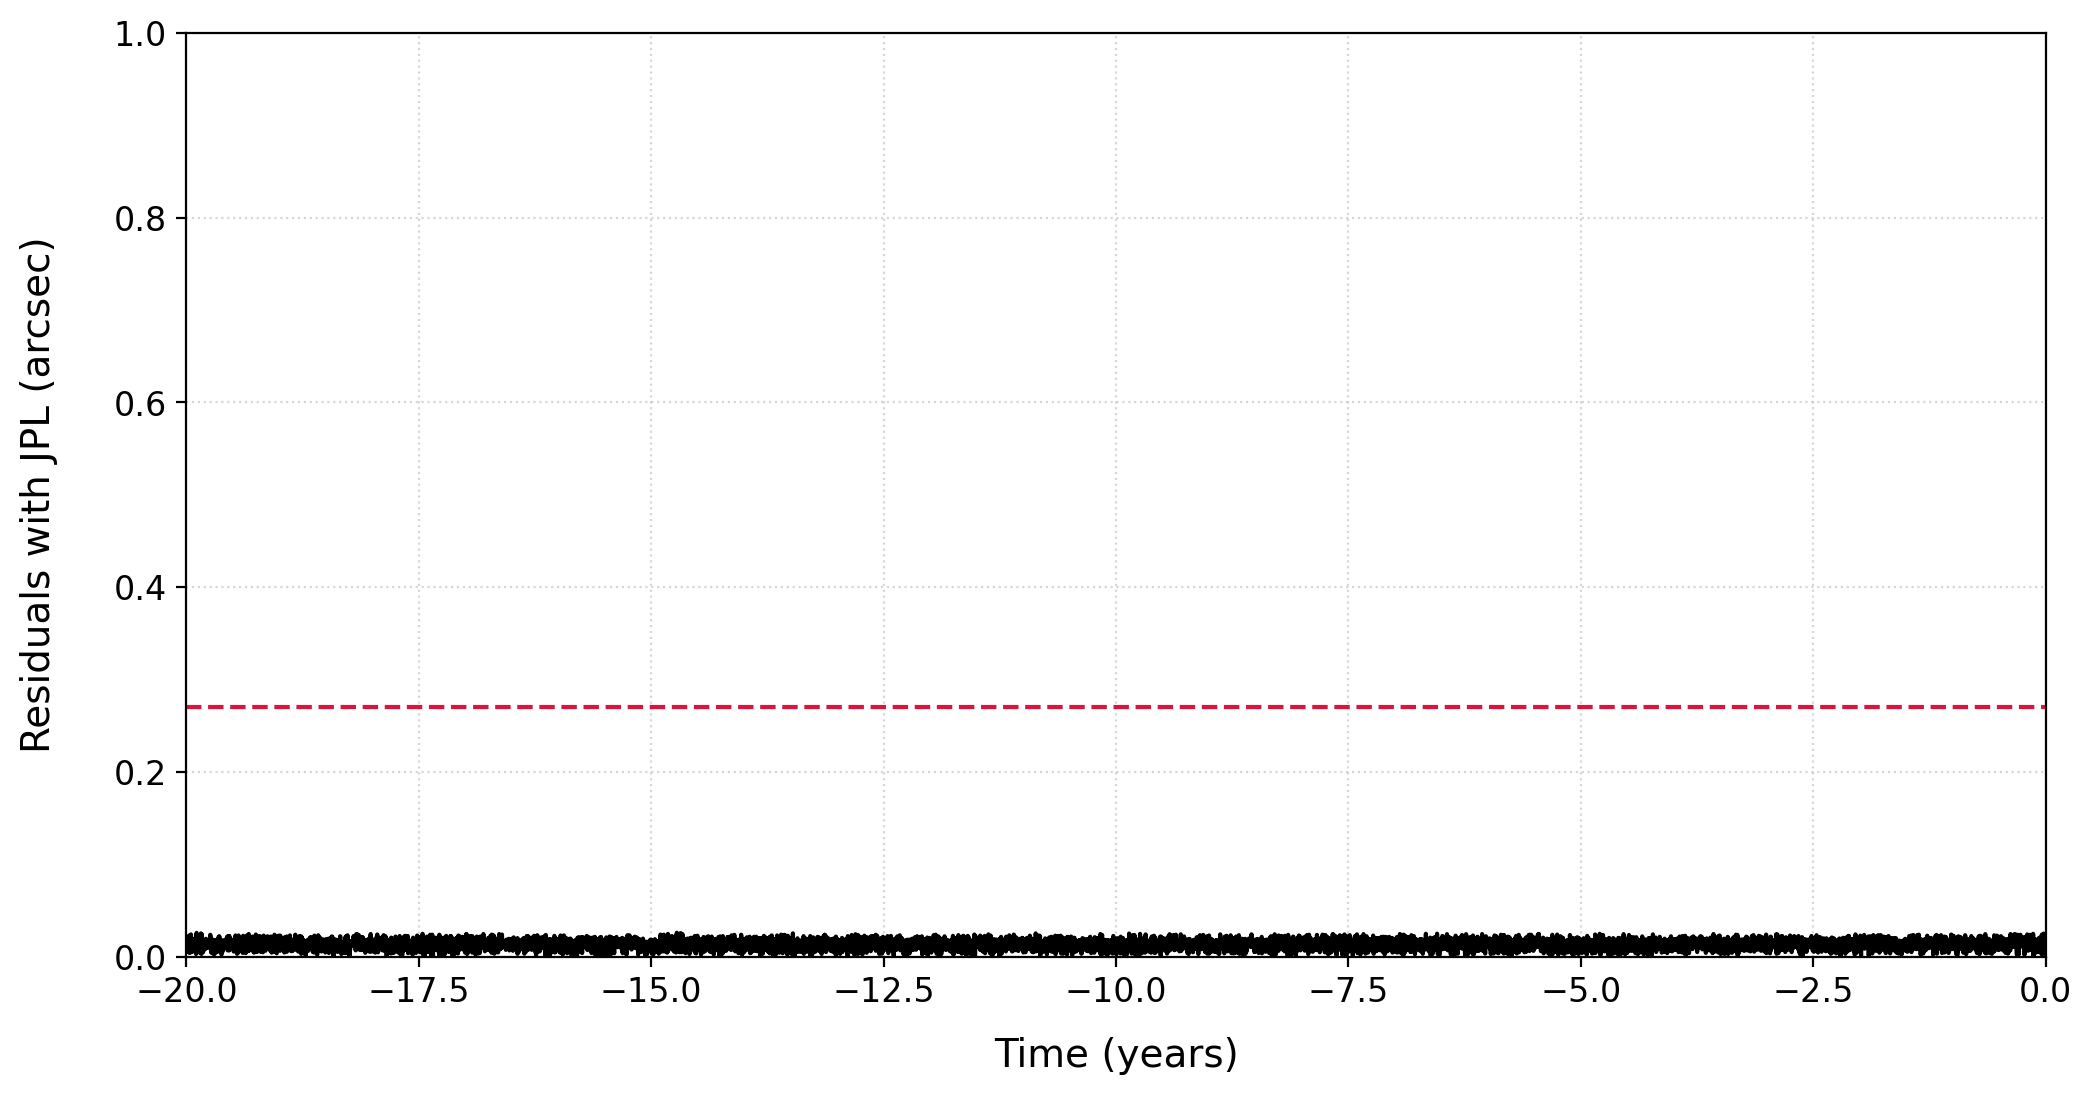

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ra_residuals = (ephem_Horizons['RA'] - ras) * 3600
dec_residuals = (ephem_Horizons['DEC'] - decs) * 3600
residuals = np.sqrt(ra_residuals**2 + dec_residuals**2)

t = (epochs - t0) / 365.25
ax.plot(t, residuals, label='Residuals', color='black')

ax.axhline(0.27, color='crimson', ls='--')
#ax.text(0.1, 0.27+0.01, 'DECam Pixel Scale', color='crimson', fontsize=12, va='bottom', ha='left')

ax.set_xlabel('Time (years)', fontsize=14, labelpad=10)
ax.set_ylabel('Residuals with JPL (arcsec)', fontsize=14, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylim(bottom=0, top=1)
#ax.set_yscale('log')
ax.set_xlim(left=t.min(), right=t.max())
ax.grid(ls=':', alpha=0.5)

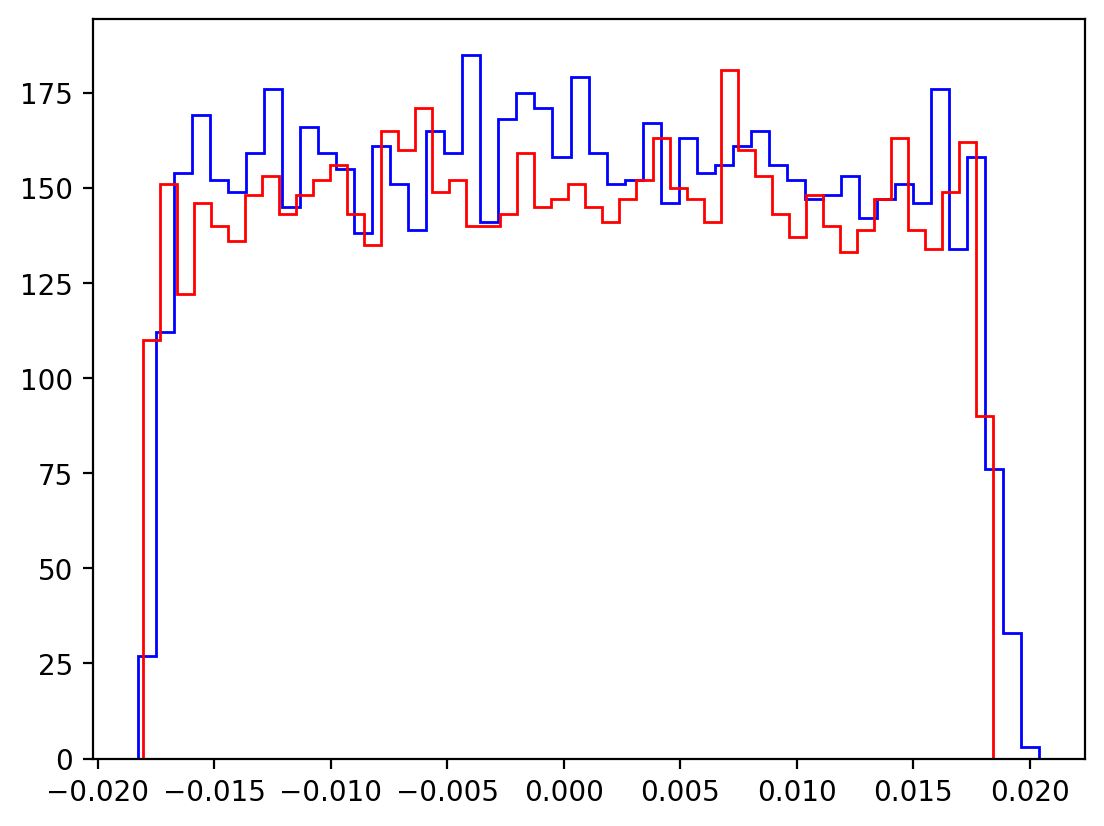

In [25]:
_ = plt.hist(ra_residuals, bins=50, histtype='step', color='blue', label='RA')
_ = plt.hist(dec_residuals, bins=50, histtype='step', color='red', label='Dec')

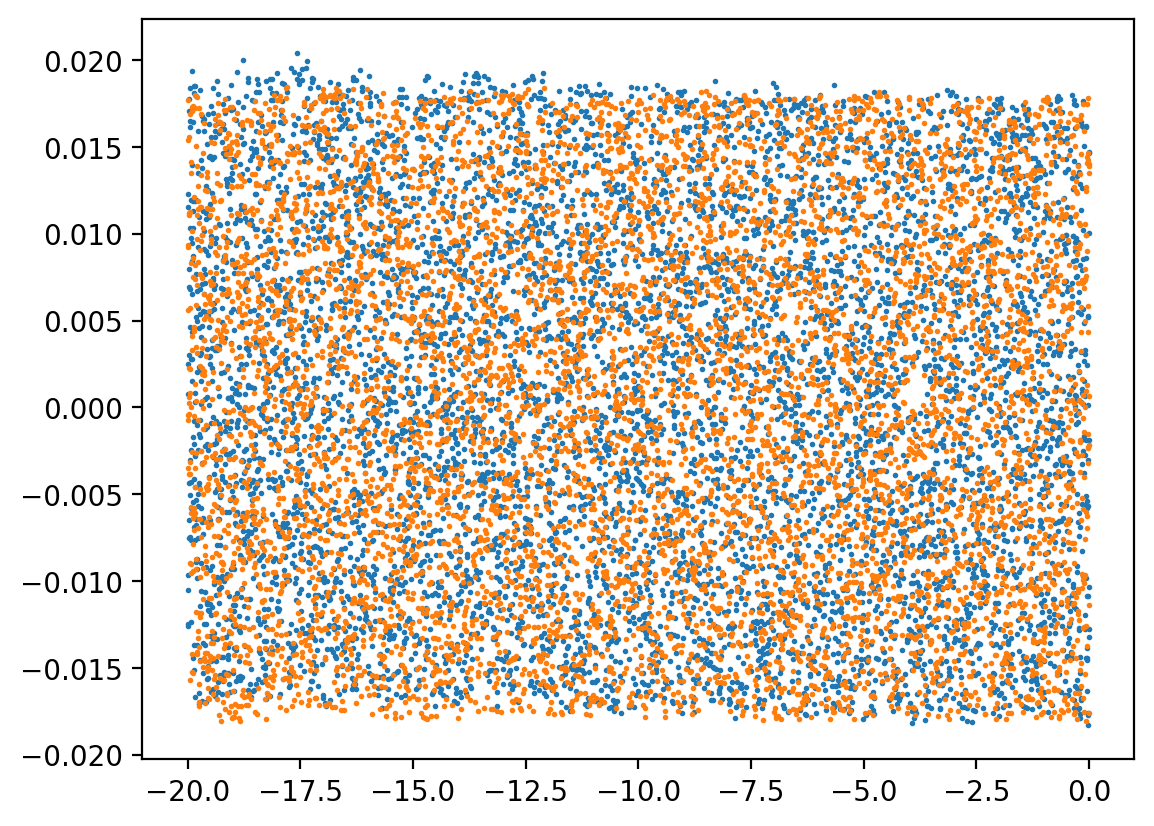

In [26]:
plt.scatter(t, ra_residuals, s=1)
plt.scatter(t, dec_residuals, s=1)